# Evolving and reconverging UEDGE cases using UETOOLS

## TOC:
* [Time-stepping in UEDGE](#time-stepping)
* [Starting a simulation](#starting-simulation)
* [The time-dependent solver](#time-dependent-solver)
* [The continuation solver](#continuation-solver)
* [Interrupting UEDGE evaluations and solvers](#interrupting)
* [Analyzing the troublemaker equation](#troublemaker)
* [Losing track of your changes?](#losing-track)

In [1]:
# Restore the case
from os import chdir
chdir('testcase_hires')
from uetools import Case
c = Case('input.yaml') # Create a test at variable "c" from the YAML input file

UEDGE configuration file /Users/holm10/.uetoolsrc read.
Saved solution successfully restored from nc20.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 2.27e+00



## Time-stepping in UEDGE<a class="anchor" id="time-stepping"></a>
In UEDGE, a time-step of size bbb.dtreal is attempted at each evaluation of the function bbb.exmain(). If a solution is found for the set of equations being solved (see UEDGE documentation), the time-step is deemed a success, and all UEDGE variables are updated, as was discussed in Chapter 2. 

For finite time-steps, subsequent time-steps will keep evolving the solution owing to the $\frac{\mathrm{d}}{\mathrm{d}t}$-term present in the equation. However, if the time-step is infinite, the simulation is at steady-state and subsequent evaluation will not evolve. This is typically the desired state of a UEDGE case, since the convergence of the simulation to within machine precision can be verified. 

This chapter will present ways to attain a steady-state solution for UEDGE and re-converging a simulation after a change in a setup variable.

### Exmain
As stated above, the function bbb.exmain() is the driver of a UEDGE simulation and can be accessed directly from UEDGE or, alternatively, from it's UETOOLS counterpart, Case.exmain(), which is a wrapped version of bbb.exmain().

In [2]:
from time import sleep
print("Time-step is: bbb.dtreal=",bbb.dtreal, '\n') # Check that we are at steady-state
bbb.exmain() # Take a time-step
sleep(1)
print('\nSuccessful time-step since fnrm<', bbb.ftol,'\n\n\n')
c.exmain()
sleep(1)
print('\nSuccessful time-step from Case.exmain()')

Time-step is: bbb.dtreal= 1e+20 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.1097328273647610E-03 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.2459366752234122E-05 nfe=     24
 iter=    2 fnrm=     0.2157500781245136E-10 nfe=     48


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1

Successful time-step since fnrm< 1e-08 



 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gr

## Starting a UEDGE simulation<a class="anchor" id="starting-simulation "></a>

When starting a new UEDGE simulation, it is recommended to start from a previously converged UEDGE simulation and make incremental changes. Thus, this tutorial will focus on how to incrementally modify cases, which is the preferred and recommended method.

## Time-dependent solver<a class="anchor" id="time-dependent-solver"></a>
The first way to reconverge a UEDGE case is the time-dependent solver, which is part of UEDGE. Here, the wrapped version of UETOOLS, Case.converge, will be the focus. After a change is made to the UEDGE setup (such as changing a boundary condition value), the time-dependent solver attempts to evolve the equations by small time-steps, which are progressively evolved to develop the solution until the solution is sufficiently close to its steady-state to accommodate $dt\rightarrow\infty$.

Time-dependent runs are is the ideal solver when making discrete changes to the simulation (e.g. changing the grid, switching physics models), as it does not necessitate an intial steady-state solution. However, if changing a continuous parameter, it is advisable to change the paramaeter in small increments. This is recommmended to allow the closest minima, which the solver looks for, be the global minima of the residuals (e.g. the steady-state solution). If large changes are made to variables, the initial state may be sufficiently far away form the steady-state solution that the solver ends up into local minima, which are not the steady-state solution. This results in long computational times and, in some cases, causes the simulations to not achieve converge at all.

There are several parameters that can be used to control the time-dependent run, the most central of which are presented below:
- dtreal: the initial time-step the runs tarts from
- savefname: the name of intermediate save files writte (\<savefname\>\_last\_ii2.hdf5)
- ii1_max: total number of outer iterations, determining the stopping point of unsuccessful simulations\
- ftol_min: the value of ftol to be achieved for a run to be terminated as a success

In [3]:
bbb.ncore[0]=20e18
c.restore_save('nc20.hdf5')

Saved solution successfully restored from nc20.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 2.27e+00



In [4]:
bbb.ncore[0] *= 1.10 # Increase the core density by 5%
c.converge(savefname='ncore_test', dtreal=1e-6) # Intialize a time-dependent run

Requested save-path ../solutions not found, writing to cwd!
*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1
---------------------------------------------------------------
*** Number of time-step changes = 1 New time-step: 1.00E-06 ***
---------------------------------------------------------------
 iter=    0 fnrm=     0.4000000149119181     nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.1018190344898214E-01 nfe=      4
 iter=    2 fnrm=     0.9606429880265170E-05 nfe=      8


 nksol ---  iterm = 1.
          

 iter=    0 fnrm=     0.1048926902497832     nfe=      1
 iter=    1 fnrm=     0.2228992888258110E-03 nfe=      4
 iter=    2 fnrm=     0.2457848956772026E-06 nfe=     12


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 1.6200E-05; Timestep = 3.4000E-06 

 Inner iteration #4 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.9702570157903308E-01 nfe=      1
 iter=    1 fnrm=     0.1732534022546673E-03 nfe=      5
 iter=    2 fnrm=     0.4529234680871780E-06 nfe=     13


 nksol ---  iterm = 1.
            max

Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 1.3506E-04; Timestep = 3.9304E-05 

 Inner iteration #2 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1142969614007116     nfe=      1
 iter=    1 fnrm=     0.1415131580486671E-01 nfe=      6
 iter=    2 fnrm=     0.1018205490222122E-04 nfe=     10


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 1.7437E-04; Timestep = 3.9304E-05 

 Inner iteration #3 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE     

  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.1057349364232506     nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.1525669247494428E-01 nfe=      8
 iter=    2 fnrm=     0.2219911058207986E-03 nfe=     13
 iter=    3 fnrm=     0.3810520204347465E-07 nfe=     19


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Inner iteration #1 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.8771413523881096E-01 nfe=      1
 iter=    1 fnrm=     0.5448691572146847E-02 nf

 iter=    0 fnrm=     0.5194958604467120E-01 nfe=      1
 iter=    1 fnrm=     0.3254684869921463E-03 nfe=     22
 iter=    2 fnrm=     0.1476579423308970E-04 nfe=     51
 iter=    3 fnrm=     0.3785611009823588E-07 nfe=     80


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Inner iteration #1 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 Total time = 3.2537E-03; Timestep = 5.0484E-05 

** Fortran index of trouble making equation is:
6370
** Number of equations solved per cell:
    numvar = 13

** Troublemaker equation is:
Gas density equ

 iter=    0 fnrm=     0.4792220439418259E-01 nfe=      1
 iter=    1 fnrm=     0.5390477521422716E-02 nfe=      9
 iter=    2 fnrm=     0.5521461026144678E-02 nfe=     17
 iter=    3 fnrm=     0.4457746976921517E-02 nfe=     25
 iter=    4 fnrm=     0.3985592976335546E-02 nfe=     36
 iter=    5 fnrm=     0.2841604570897483E-02 nfe=     45
 iter=    6 fnrm=     0.8781067684668798E-06 nfe=     52


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 3.3603E-03; Timestep = 5.6093E-06 

 Inner iteration #5 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms      

 iter=    0 fnrm=     0.4722553082069876E-01 nfe=      1
 iter=    1 fnrm=     0.3715301772886661E-04 nfe=      5
 iter=    2 fnrm=     0.6725538889761741E-08 nfe=     11


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 3.5869E-03; Timestep = 5.7215E-05 

 Inner iteration #3 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.4727358954658634E-01 nfe=      1
 iter=    1 fnrm=     0.3461961118535833E-04 nfe=      5
 iter=    2 fnrm=     0.5049907597988912E-08 nfe=     11


 nksol ---  iterm = 1.
            max

 iter=    0 fnrm=     0.4325863560767315E-01 nfe=      1
 iter=    1 fnrm=     0.2229570614236218E-02 nfe=      8
 iter=    2 fnrm=     0.1087201616114290E-05 nfe=     15


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 5.6443E-03; Timestep = 6.6141E-04 

 Inner iteration #2 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.4100311892951093E-01 nfe=      1
 iter=    1 fnrm=     0.1125885996048460E-02 nfe=      8
 iter=    2 fnrm=     0.3402294959521043E-06 nfe=     15


 nksol ---  iterm = 1.
            max

  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.3714654978289707E-02 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.1291894219358681E-02 nfe=     17
 iter=    2 fnrm=     0.1185685972284793E-05 nfe=     31


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Inner iteration #1 

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2067043461033552E-02 nfe=      1
 iter=    1 fnrm=     0.7409459900590336E-03 nfe=     17
 iter=    2 fnrm=     0.2988611278630328E-06 nf

Intermediate solution written to ./ncore_test_last_ii2.hdf5
 Total time = 1.9830E-01; Timestep = 2.5996E-02 

----------------------------------------------------------------
*** Number of time-step changes = 18 New time-step: 8.84E-02 ***
----------------------------------------------------------------
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.2724546267041072E-05 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.1196201426906282E-08 nfe=     25


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                 

As can be seen from the above output, the time-dependent run-function reports its progress, as the intial fnrm is reduced towards ftol_min, and the final runtime upon completion. After each internal iteration at a given time-step, the function writes an intermediate solution based on the the savefname kwarg. Whenever a time-step fails, the script reports information on the identified troublemaker variable. This save contains additional data pertaining to the progress and failure modes of the time-dependent run, which can be accessed.

### Convergence analysis
It may be useful to look at the behavior of fnrm as the time-dependent run progresses to recognize how frnm and dtreal evolves during the script evaluation:

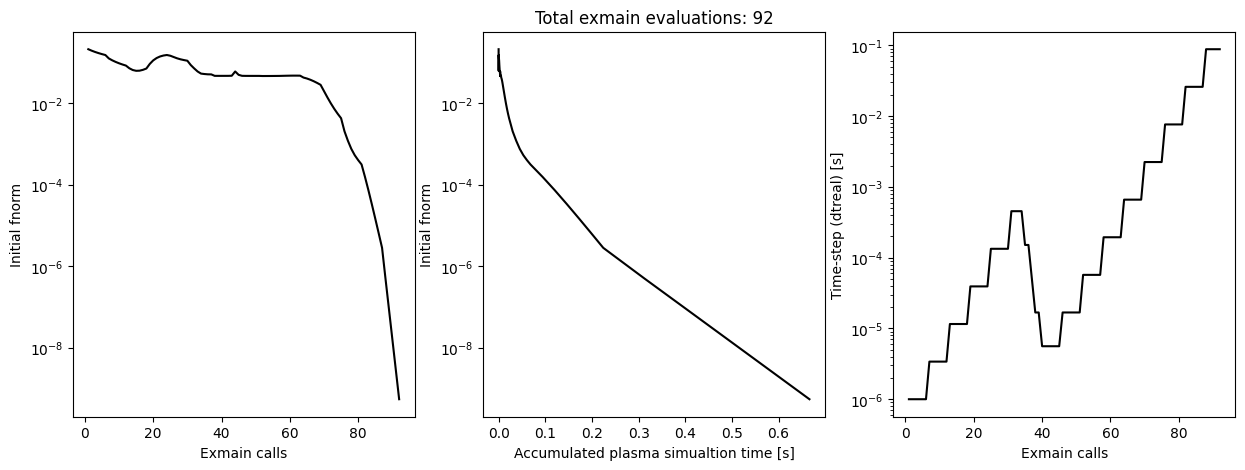

In [5]:
c.convergenceanalysis('ncore_test_last_ii2.hdf5');

The first pane shows the evolution of fnrm as a function of exmain evaluations, the middle pane fnrm as a function of the simulations time (plasma time, not wall-clock), and the leftmost the evolution of the time-step dreal as a function of exmain evaluations. Failures to advance the by a time-step is seen as a reduction in dtreal. 

The Case.convergenceanalysis script has a number of additional options:

In [6]:
help(c.convergenceanalysis)

Help on method convergenceanalysis in module uedge.rundt:

convergenceanalysis(savefname, fig=None, xaxis='exmain', logx=False, color='k', label=None, ylim=(None, None)) method of uetools.UeCase.Case.Case instance



### Failure analysis
If a case is troublesome to converge, it can be useful to look at the statistics of the failure modes for the simulation. For the above simulation, there are only a few failures so statistics will be poor, but it will give an idea about the Case.failureanalysis function nonetheless.


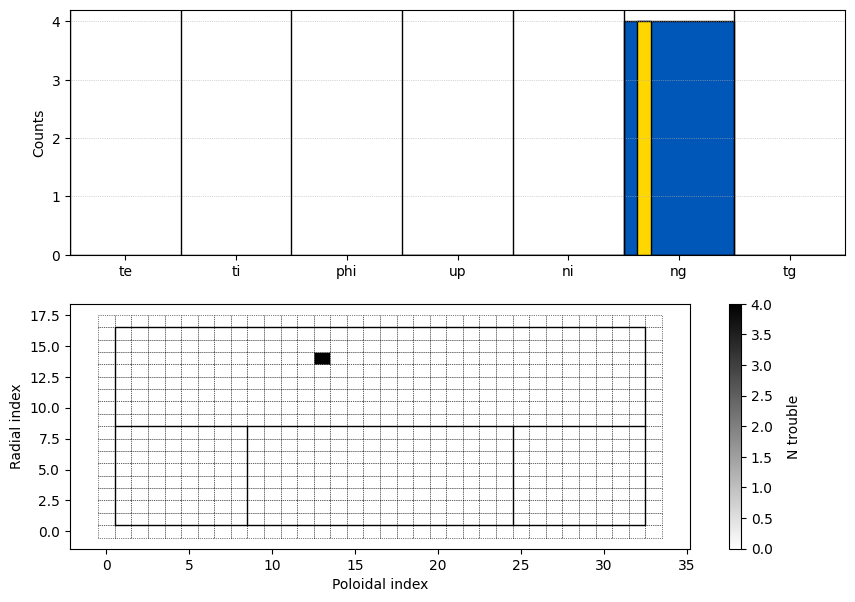

In [7]:
c.failureanalysis('ncore_test_last_ii2.hdf5');

The analysis indicates which equation failed (blue bars in bar chart) and, in the case of multi-dimensional arrays, also the specific sub-index which failed (yellow bar in bar chart). The index-space heatmap indicates which in cell(s) the equation could not be solved. For the example here, it is the neutral carbon equation that failed at the inboard SOL.

Once there are more failure modes during a simulation, it may be useful to separate the index-space locations for failures by equation using the kwarg "equation" (e.g. "tg", "ti", "ni", etc.), or only plot the first few failures using kwarg N (=slice, e.g. N=slice(0,10) for the first 10 failures). For complicated/distorted geometries, an actual geometrical representation of the grid can be used instead of the index-space heatmap by using option geometry=True.

In [8]:
help(c.failureanalysis)

Help on method failureanalysis in module uedge.rundt:

failureanalysis(savefname, equation=None, N=slice(None, None, None), geometry=False) method of uetools.UeCase.Case.Case instance



### Additional time-dependent solver options
There are a large number of time-dependent solver options for storing snapshots of the plasma solution and modifying the solver behavior:

In [9]:
help(c.converge)

Help on method converge in module uedge.rundt:

converge(dtreal=2e-09, ii1max=5000, ii2max=5, itermx=7, ftol=1e-05, dt_kill=1e-14, t_stop=100, dt_max=100, ftol_min=1e-09, incpset=7, n_stor=0, storedist='lin', numrevjmax=2, numfwdjmax=1, numtotjmax=0, tstor=(0.001, 0.04), ismfnkauto=True, dtmfnk3=0.0005, mult_dt=3.4, reset=True, initjac=True, rdtphidtr=1e+20, deldt_min=0.04, rlx=0.9, tsnapshot=None, savedir='../solutions', ii2increase=0, savefname=None, message=None) method of uetools.UeCase.Case.Case instance
    Converges the case by increasing dt 
    dtreal : float [1e-9]
        Original time-step size
    ii1max : int [500]
        Outer loop iterations, i.e. time-step changes
    ii2max : int [5]
        Inner loop iterations, i.e. time-steps per time-step change
    dt_kill : float [1e-14]
        Time-step limit for aborting simulation
    itermx : int [7]
        Maximum iterations per time-step used internally in routine
    ftol : float [1e-5]
        Internal fnrm tolerance

## Continuation solver<a class="anchor" id="continuation-solver"></a>

In situations where a steady-state solution is available, and a change to continuous variables is desired, the continuation solver is a powerful alternative to the time-dependent solver. Contrary to the time-dependent solver, the continuation solver varies the desired variable value(s) from their initial steady-state values to the desired target values in a series of steady-state exmain-evaluations for small increments to the variable. This method means every evaluation produces a steady-state solution for a state that is slightly perturbed towards the desired final state. 

The continuation solver can be significantly more efficient than the time-dependent solver when modifying the UEDGE setup, but is unable to accommodate discrete changes (such as changing grid dimension, switching physics model), when the time-dependent solver must be used. In general, it is useful to employ both solvers in parallel and employ the most efficient one.

One additional benefit of the continuation solver is that it produces a set of steady-state solutions between the initial and final states, creating a parameter scan over one or several variables. The continuation solver design also allows it to "creep up to" numerically challenging regions of parameter-space, where it will employ the time-dependent solver to bridge any bands in parameter-space where no solution exists. The incremental increase for the variable value(s) is being dynamically varied based on the algorithm success, striving to take as large as possible steps in parameter space while remaining at steady-state. In case an initial step cannot be taken, try increasing the initial resolution (e.g. steps required to achieve the target) by increasing the kwarg initres, or by reducing the target value(s).

### One-dimensional continuation solve

This example shows a continuation solve in one variable, corresponding to the above time-dependent run.

In [10]:
c.continuation_solve('ncore', target=bbb.ncore[0]*1.10, index=0, savedir='cont_solve_test')


 Initial successful time-step exists 

===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - ncore
    -Progress                             0.000%
    -Advancing by                         0.100%
    -Steps to target at current delta:    1000

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.4000000000003606E-03 nfe=      1
 iter=    1 fnrm=     0.1698145809415962E-05 nfe=     20
 iter=    2 fnrm=     0.3616884839366343E-11 nfe=     40


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to cont_solve_test/pro

 iter=    1 fnrm=     0.7539419539680124E-05 nfe=     19
 iter=    2 fnrm=     0.4634194903944429E-10 nfe=     38


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.8809319286747431E-03 nfe=      1

===== SUCCESS: ADVANCING VARIABLE ===== iter=    1 fnrm=     0.7452451767353316E-05 nfe=     19
 iter=    2 fnrm=     0.7127955673162153E-10 nfe=     38


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants

 iter=    0 fnrm=     0.1935160771116276E-02 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 6/7 =====
    -Variable(s) being solved:
                                        - ncore
    -Progress                             4.660%
    -Advancing by                         0.484%
    -Steps to target at current delta:    196

 iter=    1 fnrm=     0.3646770544562746E-04 nfe=     19
 iter=    2 fnrm=     0.1069635645512465E-08 nfe=     36


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1935200249712603E-02 nfe=   

 iter=    1 fnrm=     0.1623139802304019E-03 nfe=     18
 iter=    2 fnrm=     0.1985617368603786E-07 nfe=     34


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 2/7 =====
    -Variable(s) being solved:
                                        - ncore
    -Progress                             15.424%
    -Advancing by                         2.343%
    -Steps to target at current delta:    36

 iter=    0 fnrm=     0.9261375032344451E-02 nfe=      1
  

===== RECOVERY LOOP ENTERED ===== iter=    1 fnrm=     0.2867456344742750E-02 nfe=     19
 iter=    2 fnrm=     0.3790884876567852E-02 nfe=     28
 iter=    3 fnrm=     0.2474015937273204E-02 nfe=     34
 iter=    4 fnrm=     0.9967772724562549E-02 nfe=     41
 iter=    5 fnrm=     0.3178373135480288E-02 nfe=     45


 nksol ---  iterm = 4.
            the maximum allowable number of nonlinear
            iterations has been reached.
 Interpolants created; mype =                   -1

    -Variable(s) being solved:
                                        - ncore
    -Progress                             25.380%


===== STATIC ITERATION AT DTREAL=2.00e-04 =====
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     

Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 3.0000E-05; Timestep = 1.0000E-05 

 Inner iteration #4 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1375832314373968E-02 nfe=      1
 iter=    1 fnrm=     0.1898105130024531E-05 nfe=      5


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 4.0000E-05; Timestep = 1.0000E-05 

 Inner iteration #5 

Solving for delta=27.380%
 Reading grid data from gridue.hdf

Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Inner iteration #1 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2875088025757661E-02 nfe=      1
 iter=    1 fnrm=     0.5646108896482847E-04 nfe=      6
 iter=    2 fnrm=     0.5690306168626707E-05 nfe=     12


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 3.0253E-04; Timestep = 3.8533E-05 

 Inner iteration #2 

Solving for delta=27.380%
 Reading grid data from gri

Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 3.7532E-04; Timestep = 4.2815E-06 

 Inner iteration #3 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.3436600896829631E-02 nfe=      1
 iter=    1 fnrm=     0.7971553448698235E-04 nfe=      5
 iter=    2 fnrm=     0.3853222452037985E-06 nfe=      9


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 3.7960E-04; Timestep = 4.2815E-06 

 Inner iteration #4 

Sol

 iter=    0 fnrm=     0.2938297267978476E-02 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.9928862651263581E-06 nfe=      5


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Inner iteration #1 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2866953359332530E-02 nfe=      1
 iter=    1 fnrm=     0.9676760598091794E-06 nfe=      5


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the max

Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 1.3255E-03; Timestep = 1.4848E-04 

 Inner iteration #5 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1874613991899675E-02 nfe=      1
 iter=    1 fnrm=     0.1148326427775953E-05 nfe=     12


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 1.4739E-03; Timestep = 1.4848E-04 

----------------------------------------------------------------
*** Number of tim

 iter=    1 fnrm=     0.1439470235003431E-05 nfe=     13


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 9.8008E-03; Timestep = 1.7164E-03 

 Inner iteration #4 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.8284742710621011E-03 nfe=      1
 iter=    1 fnrm=     0.9766850964692421E-06 nfe=     13


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approxi

Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 6.9808E-02; Timestep = 1.9842E-02 

 Inner iteration #2 

Solving for delta=27.380%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.7055085886520499E-05 nfe=      1
 iter=    1 fnrm=     0.2803092573472303E-08 nfe=     24


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./cont_solve_test/progress0p274_dtrun_last_ii2.hdf5
 Total time = 8.9650E-02; Timestep = 1.9842E-02 

 Inner iteration #3 

Solving for delta=27.380%
 Reading grid data from gridue.hdf

 iter=    0 fnrm=     0.2305097135669695E-02 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 3/7 =====
    -Variable(s) being solved:
                                        - ncore
    -Progress                             29.137%
    -Advancing by                         0.586%
    -Steps to target at current delta:    121

 Reading grid data from gridue.hdf5.hdf5
 iter=    1 fnrm=     0.9025867905491572E-04 nfe=     19
 iter=    2 fnrm=     0.4722472002553711E-07 nfe=     35


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2297667375634908E-02 nfe=  

 iter=    0 fnrm=     0.5021224287018804E-02 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 5/7 =====
    -Variable(s) being solved:
                                        - ncore
    -Progress                             37.219%
    -Advancing by                         1.288%
    -Steps to target at current delta:    48

 iter=    1 fnrm=     0.2188250050936670E-03 nfe=     19
 iter=    2 fnrm=     0.1447284875155709E-06 nfe=     34


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.5022153884420318E-02 nfe=   

 iter=    1 fnrm=     0.7972027015211078E-03 nfe=     17
 iter=    2 fnrm=     0.2471250783023129E-06 nfe=     32


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1095076101320396E-01 nfe=      1

===== INNER LOOP COMPLETED: ADVANCING DELTA =====
===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - ncore
    -Progress                             60.925%
    -Advancing by                         6.236%
    -Steps to target at current delta:    6

 iter=    1 fnrm=     0.5354249207238313E-0

 Reading grid data from gridue.hdf5.hdf5 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1207270950006913E-02 nfe=      1

===== STATIC ITERATION AT DTREAL=1.00e-03 ===== iter=    1 fnrm=     0.1849965965527582E-06 nfe=     35
 iter=    2 fnrm=     0.8487728947676778E-10 nfe=     88


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.11934830784

Here, the first argument is the variable to be changed, target is the target value to be attained, and index is the index of variable, if applicable. Target can be an array, list or number, but has to be compatible with the variable and index, where variable[\*index] = target. As such, index can be defined as a tuple of length equal or less than the variable dimension, where each entry can be an integer or slice:

In [11]:
bbb.ni[*(5, slice(None), slice(2,5))]-bbb.ni[5,:,2:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

The continuation solve saves intermediate steps into the directory specified by savedir (or into a numbered directory based on the variable, if unset) which is purged at each new run.

In [12]:
!ls cont_solve_test/

progress0p001.hdf5                progress0p274_dtrun_last_ii2.hdf5
progress0p011.hdf5                progress0p315.hdf5
progress0p037.hdf5                progress0p411.hdf5
progress0p099.hdf5                progress0p672.hdf5
progress0p248.hdf5                progress1p000_staticiter.hdf5


Each of the individual HDF5 files are valid UETOOLS save files, and also contain data that can be used to compile databases as discussed in Chapter 6. Finally, if the target values is achieved, the steady-state solution for this is saved as SUCCESS_\<savedir\>.hdf5 in the current work-directory.

### Multi-dimensional continuation solve

In case varying several variables is necessary, this can be done simultaneously by the continuation solver:

In [13]:
# Define a dictionary of the variables to be solved
var = {
    'ncore': {
        'target': bbb.ncore[0]*1.05,
        'index': 0
    },
    'tcoree': {
        'target': bbb.tcoree*1.05
    },
    'tcorei': {
        'target': bbb.tcorei*1.05
    },
}

Multiple variables are defined as a nested dictionary, where each key defines the variable and the target is a dictionary containing the required key "target" and the optional key "index". This dictionary can then be passed as an argument to Case.continuation_solve.

In [14]:
c.continuation_solve(var, savedir='multivar_test')


 Initial successful time-step exists 

===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             0.000%
    -Advancing by                         0.100%
    -Steps to target at current delta:    1000

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.3591335606335569E-03 nfe=      1
 iter=    1 fnrm=     0.1521812179367244E-05 nfe=     21


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediat


===== MAIN LOOP 2/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             0.920%
    -Advancing by                         0.220%
    -Steps to target at current delta:    450

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.7623819737861133E-03 nfe=      1
 iter=    1 fnrm=     0.8971925648617952E-05 nfe=     19
 iter=    2 fnrm=     0.1092256241950491E-09 nfe=     39


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                

 iter=    1 fnrm=     0.4813493964044238E-04 nfe=     17
 iter=    2 fnrm=     0.3132627052024538E-07 nfe=     35


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1676526525720235E-02 nfe=      1
 iter=    1 fnrm=     0.5146153768418967E-04 nfe=     17
 iter=    2 fnrm=     0.5051880627773884E-07 nfe=     35


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
In

 iter=    0 fnrm=     0.1840779773165732E-02 nfe=      1

===== FAIL 2/3 =====
===== DECREASE DELTA AND TRY AGAIN =====
===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             6.160%
    -Advancing by                         0.266%
    -Steps to target at current delta:    352

 iter=    1 fnrm=     0.5833233270416957E-03 nfe=     20
 iter=    2 fnrm=     0.1134523666232594E-01 nfe=     38
 iter=    3 fnrm=     0.2864333427866910E-02 nfe=     45
 iter=    4 fnrm=     0.8834116226845461E-03 nfe=     54
 iter=    5 fnrm=     0.6304206639377338E-03 nfe=     65


 nksol ---  iterm = 4.
            the maximum allowable number of nonlinear
            iterations has been reached.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE  

 Reading grid data from gridue.hdf5.hdf5 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 2/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             6.294%
    -Advancing by                         0.133%
    -Steps to target at current delta:    704

 iter=    0 fnrm=     0.4596560923146216E-03 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.3876857850716910E-04 nfe=     21
 iter=    2 fnrm=     0.2318594135868624E-05 nfe=     39
 iter=    3 fnrm=     0.1083081856721114E-07 nfe=     58


 nksol ---  iterm = 1.


===== FAIL 1/3 ===== iter=    1 fnrm=     0.3572079860453826E-04 nfe=     51
 iter=    2 fnrm=     0.2155031663579796E-04 nfe=     81
 iter=    3 fnrm=     0.1778092678309297E-03 nfe=    115
 iter=    4 fnrm=     0.5020260845473957E-04 nfe=    127
 iter=    5 fnrm=     0.2149463774891941E-04 nfe=    151


 nksol ---  iterm = 4.
            the maximum allowable number of nonlinear
            iterations has been reached.
 Interpolants created; mype =                   -1

===== DECREASE DELTA AND TRY AGAIN =====
===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             6.294%
    -Advancing by                         0.033%
    -Steps to target at current delta:    2816

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read s

 iter=    0 fnrm=     0.1156723510463008E-05 nfe=      1
 Reading grid data from gridue.hdf5.hdf5
 iter=    1 fnrm=     0.5581400077918908E-06 nfe=     68
 iter=    2 fnrm=     0.1814151447565052E-05 nfe=    126
 iter=    3 fnrm=     0.6331945198180722E-06 nfe=    172
 iter=    4 fnrm=     0.8489241776413327E-06 nfe=    228
 iter=    5 fnrm=     0.5395453337909530E-06 nfe=    281


 nksol ---  iterm = 4.
            the maximum allowable number of nonlinear
            iterations has been reached.
 Interpolants created; mype =                   -1
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
  Updating Jacobian, npe =                      1

 Initial successful time-step exists 

---------------------------------------------------------------
*** Number of time-step changes = 1 New time-step: 1.00E-05 ***
----------

Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 1.2800E-04; Timestep = 3.4000E-05 

 Inner iteration #3 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1506743170893105E-02 nfe=      1
 iter=    1 fnrm=     0.1090827899991506E-05 nfe=      6


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 1.6200E-04; Timestep = 3.4000E-05 

 Inner iteration #4 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5

Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Inner iteration #1 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2411473048582810E-02 nfe=      1
 iter=    1 fnrm=     0.4195914399509495E-05 nfe=      9


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 5.0804E-04; Timestep = 1.2844E-05 

 Inner iteration #2 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBA

Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 5.7227E-04; Timestep = 4.2815E-06 

 Inner iteration #4 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.3308538121937539E-02 nfe=      1
 iter=    1 fnrm=     0.4210936976399730E-03 nfe=      5
 iter=    2 fnrm=     0.4652376427004767E-04 nfe=     10
 iter=    3 fnrm=     0.9102494775711265E-06 nfe=     15


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 5.7655E-0

 iter=    1 fnrm=     0.7672068715506766E-02 nfe=      6
 iter=    2 fnrm=     0.3309047950604590E-03 nfe=     11
 iter=    3 fnrm=     0.7176933450771143E-06 nfe=     17


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Inner iteration #1 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1193036573741863E-01 nfe=      1
 iter=    1 fnrm=     0.1315127511381845E-03 nfe=      6
 iter=    2 fnrm=     0.1016493226599158E-06 nfe=     13


 nksol ---  iterm = 1.
            maxno

Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 6.7331E-04; Timestep = 1.4557E-05 

 Inner iteration #5 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2257606677561765E-02 nfe=      1
 iter=    1 fnrm=     0.1688517432870384E-06 nfe=      4


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 6.8787E-04; Timestep = 1.4557E-05 

----------------------------------------------------------------
*** Number of time-ste

Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 1.5042E-03; Timestep = 1.6828E-04 

 Inner iteration #4 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1601536767095647E-02 nfe=      1
 iter=    1 fnrm=     0.6347831822235199E-06 nfe=      7


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 1.6725E-03; Timestep = 1.6828E-04 

 Inner iteration #5 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5

 iter=    1 fnrm=     0.3981860060346685E-06 nfe=     14


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 9.3326E-03; Timestep = 1.9453E-03 

 Inner iteration #3 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1912126819992460E-03 nfe=      1
 iter=    1 fnrm=     0.1680645671864768E-06 nfe=     14


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximat

 iter=    1 fnrm=     0.1608578399538632E-09 nfe=     25


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
Intermediate solution written to ./multivar_test/progress0p083_dtrun_last_ii2.hdf5
 Total time = 7.9286E-02; Timestep = 2.2488E-02 

 Inner iteration #2 

Solving for delta=8.343%
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.5973277673605996E-06 nfe=      1
 iter=    1 fnrm=     0.1476200824886876E-09 nfe=     25


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximat

 iter=    0 fnrm=     0.5744834838946669E-04 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 4/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             8.410%
    -Advancing by                         0.017%
    -Steps to target at current delta:    5505

 iter=    1 fnrm=     0.4257810744643113E-07 nfe=     23


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    

 iter=    0 fnrm=     0.1263601752261975E-03 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 7/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             8.696%
    -Advancing by                         0.037%
    -Steps to target at current delta:    2494

 iter=    1 fnrm=     0.1985505588659813E-06 nfe=     22


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      

===== INN


===== INNER LOOP COMPLETED: ADVANCING DELTA ===== iter=    1 fnrm=     0.1444305435248661E-04 nfe=     20
 iter=    2 fnrm=     0.1372285568950529E-09 nfe=     40


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1

===== MAIN LOOP 1/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             9.296%
    -Advancing by                         0.177%
    -Steps to target at current delta:    511

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 

  Updating Jacobian, npe =                      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 2/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             10.926%
    -Advancing by                         0.390%
    -Steps to target at current delta:    228

 iter=    0 fnrm=     0.1343241988819317E-02 nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=     0.1859204189978964E-04 nfe=     18
 iter=    2 fnrm=     0.2138469891349780E-09 nfe=     37


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D  

 Reading grid data from gridue.hdf5.hdf5 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.2954485634404127E-02 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 4/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             15.837%
    -Advancing by                         0.857%
    -Steps to target at current delta:    98

 iter=    1 fnrm=     0.9812360301465093E-04 nfe=     16
 iter=    2 fnrm=     0.3567318988598216E-08 nfe=     34


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Inte

 iter=    0 fnrm=     0.6488763804623519E-02 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 5/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             26.812%
    -Advancing by                         1.886%
    -Steps to target at current delta:    38

 iter=    1 fnrm=     0.5581370464662249E-03 nfe=     16
 iter=    2 fnrm=     0.1597212336782466E-06 nfe=     32


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/

 Reading grid data from gridue.hdf5.hdf5 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    

 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0 fnrm=     0.1423224416423576E-01 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 6/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             53.221%
    -Advancing by                         4.150%
    -Steps to target at current delta:    11

 iter=    1 fnrm=     0.8595276270207302E-02 nfe=     15
 iter=    2 fnrm=     0.1209654391163437E-04 nfe=     24
 iter=    3 fnrm=     0.2199094264645691E-09 nfe=     43


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  


===== SUCCESS: ADVANCING VARIABLE ===== iter=    1 fnrm=     0.5356690648727082E-03 nfe=     18
 iter=    2 fnrm=     0.8373141347509749E-06 nfe=     35


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1

===== MAIN LOOP 4/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             68.369%
    -Advancing by                         2.282%
    -Steps to target at current delta:    13

 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file name:   gridue.hdf5.hdf5
     run-ID:      EFITD    05/08/2002    #110465  3500ms                      
 iter=    0

 iter=    0 fnrm=     0.1683833907653803E-01 nfe=      1

===== SUCCESS: ADVANCING VARIABLE =====
===== MAIN LOOP 5/7 =====
    -Variable(s) being solved:
                                        - ncore
                                        - tcoree
                                        - tcorei
    -Progress                             97.585%
    -Advancing by                         5.021%
    -Steps to target at current delta:    0

 iter=    1 fnrm=     0.2552516569298479E-02 nfe=     15
 iter=    2 fnrm=     0.2643425271159147E-05 nfe=     27
 iter=    3 fnrm=     0.8574400054190022E-09 nfe=     47


 nksol ---  iterm = 1.
            maxnorm(sf*f(u)) .le. ftol, where maxnorm() is
            the maximum norm function.  u is probably an
            approximate root of f.
 Interpolants created; mype =                   -1
 Reading grid data from gridue.hdf5.hdf5
 TARGET MATERIAL IS      GRAPHITE         
 BOMBARDING IONS ARE     D    
 Grid data read successfully:
     file na

### Additional continuation solver options

There is also a number of options for controlling the continuation solver behavior, and any additional kwargs are passed to the time-dependent solver. Providing the user full flexibility of the solver options

In [15]:
help(c.continuation_solve)

Help on method continuation_solve in module uedge.rundt:

continuation_solve(var, target=None, savedir=None, index=None, dt=0.02, dtreal=1e-05, ftol=1e-05, iicont_max=7, iicont_fail_max=3, cutoff=1000000.0, itermx=5, incpset=8, initres=1000, deltafac=2, dtdeltafac=2, staticiter_max=3, dtlim=10000.0, ii1max=150, saveres=7, **kwargs) method of uetools.UeCase.Case.Case instance
    Solves var up to target using continuation method
    var - string for variable, or nested dict of variables and targets
            If nested dict, top level is variable name and subdict contains
            keys 'target' and optionally 'index'. These values override the 
            kwargs of the solver. If index is not set, defaults to None
    target - target value for variable
    index - tuple containing index of var if var is array.
            In case of extended array slicing, e.g. setting ranges of
            var, index must be defined as tuples of indices and/or 
            slice objects. E.g. to s

## Interrupting simulations/evaluations<a class="anchor" id="interrupting"></a>
When using UEDGE in an interactive manner via the Python command prompt, any evaluation of exmain or a solver can be interrupted to diagnose the case and, if necessary, abort the evaluation. This is done using "Ctrl+c", which brings up an interactive prompt. The options are to print a variable value using regular Python syntax, continue the evaluation by typing "continue", or aborting the current evaluation by writing "abort", which returns the user to the Python prompt.

## Analyzing the current troublemaker<a class="anchor" id="troublemaker"></a>
If you have a particularly troublesome case, or are debugging UEDGE, it may be useful to identify and analyze the "troublemaker" equation and cell. The "troublemaker" equation is identified as the individual equation corresponding to a particular cell that has the highest residual of all the equations solved. Thus, there is a troublemaker even for converged cases! Let's take a look:

In [16]:
c.itroub()

** Fortran index of trouble making equation is:
7318
** Number of equations solved per cell:
    numvar = 13

** Troublemaker equation is:
Ion energy equation: iv_t=12

** Troublemaker cell (ix,iy) is:
[18 16]

** Timestep for troublemaker equation:
1.0000e+20

** yl for troublemaker equation:
2.4864e-01

** yldot*sfscal for troublemaker equation:
1.1626e-10



## Losing track of your changes?<a class="anchor" id="losing-track"></a>

It is not uncommon to make changes you forget about and create a new save file, only to discover your input file no longer is converged because you forgot to update it. Good new, UETOOLS has methods for finding the changes. 

### Restoring from the save-file
You can always try to restore the case from the save-file directly, as explained in Chapter 2. This should always result in a converged case. THen you can do away with the input-file completely! Or, you can run h5diff on the new and old files to look for variables that have changed.

Note: if a case restored from the save-file is not converged, please contact the UETOOLS developers by email or by submitting an issue to the GitHub tracker with the files, as this method should always work.

### Looking at tracked changes
UETOOLS hashes all input variables when a Case object is created, tracks them, and saves any changed variables in the save file. A list of the changed variables can be printed using the Case.get_detected_changes function:

In [18]:
c.get_detected_changes('ncore_test_last_ii2.hdf5')

albedoi
albedoo
alblb
albrb
alfe
betai
chgstate_format
coll_fe
coll_fi
flalfea
flalfgxa
flalfgxya
flalfgya
flalfia
flalftgxa
flalftgxya
flalftgya
flalfva
flalfvgxa
flalfvgxya
flalfvgya
iesori
iesoro
issori
issoro
lynix
lyphix
lytex
lytix
ncore
nfsp
nibprof
recylb
recyrb
tebprof
tewalli
tewallo
tibprof
tiwalli
tiwallo
tvapi
tvaplb
tvapo
tvaprb
upbprof


As evident from above, changes are detected to many variables that have not been modified. This is due to these arrays being populated based on other input variables. However, for certain settings these variables may be user-defined and, thus, can be input variables even though they are not in this case. Hence, these variables are also tracked. In the future, dynamic detection might be implemented to detect whether a variable is active. 

Presently, the detected changes can still be a useful tool for detecting changes to cases that one might otherwise forget about: as one can see, ncore is present in the list, which is the variable changed before reconverging the case. 